<a href="https://colab.research.google.com/github/harsh-ux/PRML-project/blob/main/Pill_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, recall_score, precision_score

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
# train = pd.read_csv('drive/My Drive/drugsComTrain_raw.csv')
# test = pd.read_csv('drive/My Drive/drugsComTest_raw.csv')
train = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTrain_raw.csv')
test = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTest_raw.csv')
# getting the shapes
print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

Mounted at /content/drive
Shape of train : (161297, 7)
Shape of test : (53766, 7)


In [3]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


# Preprocessing

In [5]:
# as both the dataset contains same columns we can combine them for better analysis
data = pd.concat([train, test])

# checking the shape
data.shape

(215063, 7)

In [6]:
data.describe()

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


Extracting year,month and day from the date column

In [8]:
# converting the date into datetime format
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# now extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from the date
data['month'] = data['date'].dt.month

# extracting the days from the date
data['day'] = data['date'].dt.day

Check for null values

In [9]:
data.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
Year           False
month          False
day            False
dtype: bool

Add review sentiment column which acts as target variable. It gives a (good,bad)-(1,0) value based on rating of the drug

In [61]:
# feature engineering 
# let's make a new column review sentiment 

data.loc[(data['rating'] >= 7), 'Review_Sentiment'] = 2
data.loc[(data['rating']== 5), 'Review_Sentiment'] = 1
data.loc[(data['rating']== 6), 'Review_Sentiment'] = 1
data.loc[(data['rating']<5), 'Review_Sentiment'] = 0
data['Review_Sentiment'].value_counts()

2.0    105531
0.0     39579
1.0     14154
Name: Review_Sentiment, dtype: int64

In [30]:
data['condition'].isnull().sum()

0

In [31]:
# we will delete the rows so that the data does not overfits 

data = data.dropna(axis = 0)

# checking the new shape of the data
data.shape

(159332, 12)

In [32]:
# importing the important libraries 

import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [34]:
data.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Year', 'month', 'day', 'Review_Sentiment',
       'review_clean'],
      dtype='object')

In [35]:
df_condition = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
673,"Aspergillosis, Aspergilloma",1
674,Ventricular Arrhythmia,1
675,Keratitis,1
676,Giant Cell Tumor of Bone,1
677,"Skin Disinfection, Preoperative",1
678,Postoperative Increased Intraocular Pressure,1
679,Reversal of Nondepolarizing Muscle Relaxants,1
680,Small Bowel or Pancreatic Fistula,1
681,Platelet Aggregation Inhibition,1
682,Syringomyelia,1


Removing medical conditions which have only one drug associated with it in the dataset

In [36]:
# setting a df with conditions with only one drug
df_condition_1 = df_condition[df_condition['drugName'] == 1].reset_index()

all_list = set(data.index)

# deleting them
condition_list = []
for i,j in enumerate(data['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

removing the conditions with the word "\span" in it.


In [37]:
all_list = set(data.index)
span_list = []
for i,j in enumerate(data['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

In [38]:
data.shape

(159264, 12)

# Applying data cleanup with -


1.   Removing HTML tags
2.   Removing non letters
3.   Convert all to lower case
4.   Remove stopwords
5.   Apply stemming



In [39]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 5. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 6. space join words
    return( ' '.join(stemming_words))

In [40]:
%time data['review_clean'] = data['review'].apply(review_to_words)

CPU times: user 1min 43s, sys: 319 ms, total: 1min 44s
Wall time: 1min 44s


Using the entire data as for test and train instead of the original breakup since all have same columns

In [41]:
df_train, df_test = train_test_split(data, test_size = 0.25, random_state = 0)

# checking the shape 
print("Shape of train:", df_train.shape)
print("Shape of test: ", df_test.shape)

Shape of train: (119448, 12)
Shape of test:  (39816, 12)


Making a bag of words using CountVectorise

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 5000, lowercase=True, binary=True)
# cv = CountVectorizer()
pipeline = Pipeline([('vect',cv)])

# df_train_features = pipeline.fit_transform(df_train['review_clean'])
# df_train_features = cv.fit_transform(df_train['review_clean']).toarray()
df_train_features = cv.fit_transform(df_train['review_clean'])
df_test_features = pipeline.fit_transform(df_test['review_clean'])

print("Performing Bag of Words - CountVectorise\n")
print("df_train_features :", df_train_features.shape)
print("df_test_features :", df_test_features.shape)

Performing Bag of Words - CountVectorise

df_train_features : (119499, 5000)
df_test_features : (39833, 5000)


In [24]:
df_train_features = df_train_features.toarray()

In [62]:
y_train = df_train['Review_Sentiment']
y_test = df_test['Review_Sentiment']

In [63]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [64]:
y_test.shape

(39816, 2)

# SVM

In [ ]:
svmClassifier = SVC(kernel="linear", class_weight="balanced", C=0.003)
t0 = time.time()

svmClassifier.fit(df_train_features, y_train)
t1 = time.time()

svmPredictions = svmClassifier.predict(df_test_features)
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test, svmPredictions, output_dict=True)
print('0.0: ', report['0.0'])
print('1.0: ', report['1.0'])
print('accuracy: ', report['accuracy'])
print('macro avg: ', report['macro avg'])
print('weighted avg: ', report['weighted avg'])

# Deep Learning Model

In [ ]:
# import keras 
# from keras.models import Sequential, Model
# from keras.layers import Dense, Input
# from keras.layers import Activation
# from keras.layers import Dropout
# from keras.layers import Bidirectional
# from keras.layers import BatchNormalization
# from keras.layers import LSTM
# from keras.preprocessing.sequence import pad_sequences

In [ ]:
# making our dependent variable
solution = y_test.copy()

# Model Structure
model = Sequential()
model.add(Input(shape=(df_train_features.shape[1],)))
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#  Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# inputs = Input(shape=(df_train_features.shape[1],), sparse=True)
# L1 = (Dense(200))(inputs)
# L1_N = (BatchNormalization())(L1)
# L1_Act = (Activation('relu'))(L1_N)
# L1_Drop = (Dropout(0.5))(L1_Act)
# L2 = (Dense(200))(L1_Drop)
# L2_N = (BatchNormalization())(L2)
# L2_Act = (Activation('relu'))(L2_N)
# L2_Drop = Dropout(0.5)(L2_Act)
# L3 = (Dense(100, activation = 'relu'))(L2_Drop)
# outputs = (Dense(1, activation = 'sigmoid'))(L3)
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
print(df_train_features)

In [ ]:
df_train['review_clean']

In [ ]:
def batch_generator(X, y, batch_size):
    number_of_batches = X.shape[0]/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter < number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [ ]:
# 4. Train model
hist = model.fit(df_train_features, y_train, epochs=10, batch_size=64)
# steps = 10
# for i in range(steps):
#   print(model.train_on_batch(df_train_features, y_train, ))
# print(model.metrics_names)
# batch_size = 64
# nb_epoch = 5
# model.fit_generator(generator=batch_generator(df_train_features, y_train, batch_size),
#                     epochs=nb_epoch)
# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
y_pred = model.predict(df_test_features.toarray())

In [ ]:
print(accuracy_score(y_test, y_pred))

# Deep Learning Model 2

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (KerasLayer)           (None, 128)               124642688 
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 2)                 2050      
Total params: 124,776,834
Trainable params: 134,146
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/50
934/934 [==============================] - 5s 5ms/step - loss: 0.3126 - accuracy: 0.9070
Epoch 2/50
934/934 [==============================] - 6s 6ms/step - loss: 0.2875 - accuracy: 0.9123
Epoch 3/50
934/934 [============

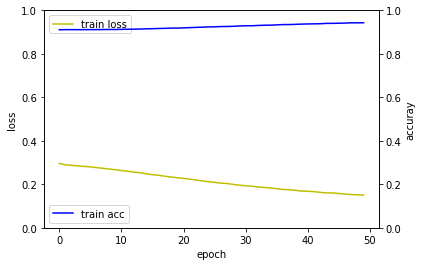

In [65]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk
import tensorflow_hub as hub
import tensorflow as tf
from numpy.random import seed
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[50], 
                           input_shape=[], dtype=tf.string, name='input', trainable=False)
np.random.seed(1)
model = Sequential()
model.add(hub_layer)
model.add(Dense(units=1024, activation='relu', input_dim=df_train_features.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
hist = model.fit(df_train['review_clean'], y_train, epochs=50, batch_size=128)

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [70]:
y_pred = model.predict(df_test['review_clean'])

In [72]:
y_pred = (y_pred > 0.5) 

In [73]:
print(accuracy_score(y_test,y_pred))

0.921740004018485


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
start = time.time()
rfc = RandomForestClassifier(n_estimators=150, random_state=42, max_depth = 1000)
rfc.fit(df_train_features, df_train['Review_Sentiment'])
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred = rfc.predict(df_test_features)

print("Accuracy: %s" % str(rfc.score(df_test_features, df_test['Review_Sentiment'])))


# Bayes Classification

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
start = time.time()
multiNB = MultinomialNB().fit(df_train_features, df_train['Review_Sentiment'])
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred = multiNB.predict(df_test_features)

print("Accuracy: %s" % str(multiNB.score(df_test_features, df_test['Review_Sentiment'])))